# 06 - Pattern Mining

Pattern Mining is a method used to find patterns, associations, correlations or causal structures among set of items. Therefore, it will be used to generate some rules for us to analyse. We'll vary the number of features and bins (cut and qcut discretization).

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd, numpy as np
from mlxtend.frequent_patterns import apriori, association_rules #for ARM
from sklearn.feature_selection import SelectKBest, f_classif
from utils import graphFunctions as graph
import matplotlib.pyplot as plt
from utils import modelAnalyzesFunctions as analyzes

In [3]:
data_9: pd.DataFrame = pd.read_csv('../datasets/pd_data_preparation_9.csv', sep=',', decimal='.', index_col='id')
df_target = data_9.iloc[:, data_9.shape[1]-1]
y_9: np.ndarray = data_9.pop('class').values
X_9: np.ndarray = data_9.values
labels_9 = pd.unique(y_9)

data_9.head()

,gender,PPE,DFA,RPDE,numPulses,stdDevPeriodPulses,locPctJitter,locShimmer,meanAutoCorrHarmonicity,meanHarmToNoiseHarmonicity,...,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_36
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.916232,0.475707,0.590235,0.284974,0.022323,0.075900,0.271284,0.944323,0.626765,...,0.013066,0.004055,0.003293,0.000374,0.000178,0.000191,0.008863,0.098628,0.031079,0.218287
1,0.0,0.182314,0.806469,0.630075,0.242228,0.689703,0.247423,0.228818,0.876238,0.577781,...,0.038398,0.008310,0.001114,0.001689,0.024783,0.018258,0.022440,0.040204,0.058074,0.017145
2,1.0,0.877689,0.216841,0.516437,0.448187,0.033848,0.087255,0.117413,0.974092,0.665577,...,0.007834,0.019385,0.000201,0.000368,0.000336,0.213153,0.204655,0.120303,0.125812,0.028947
3,0.0,0.925807,0.237611,0.542708,0.785622,0.010547,0.021814,0.161006,0.983185,0.775315,...,0.037870,0.020783,0.009404,0.018881,0.003916,0.000815,0.002275,0.009216,0.015696,0.216241
4,0.0,0.930451,0.757013,0.842307,0.532383,0.754983,0.148962,0.722861,0.734980,0.314902,...,0.022389,0.009184,0.006695,0.009538,0.010617,0.013877,0.018696,0.010267,0.090744,0.662076


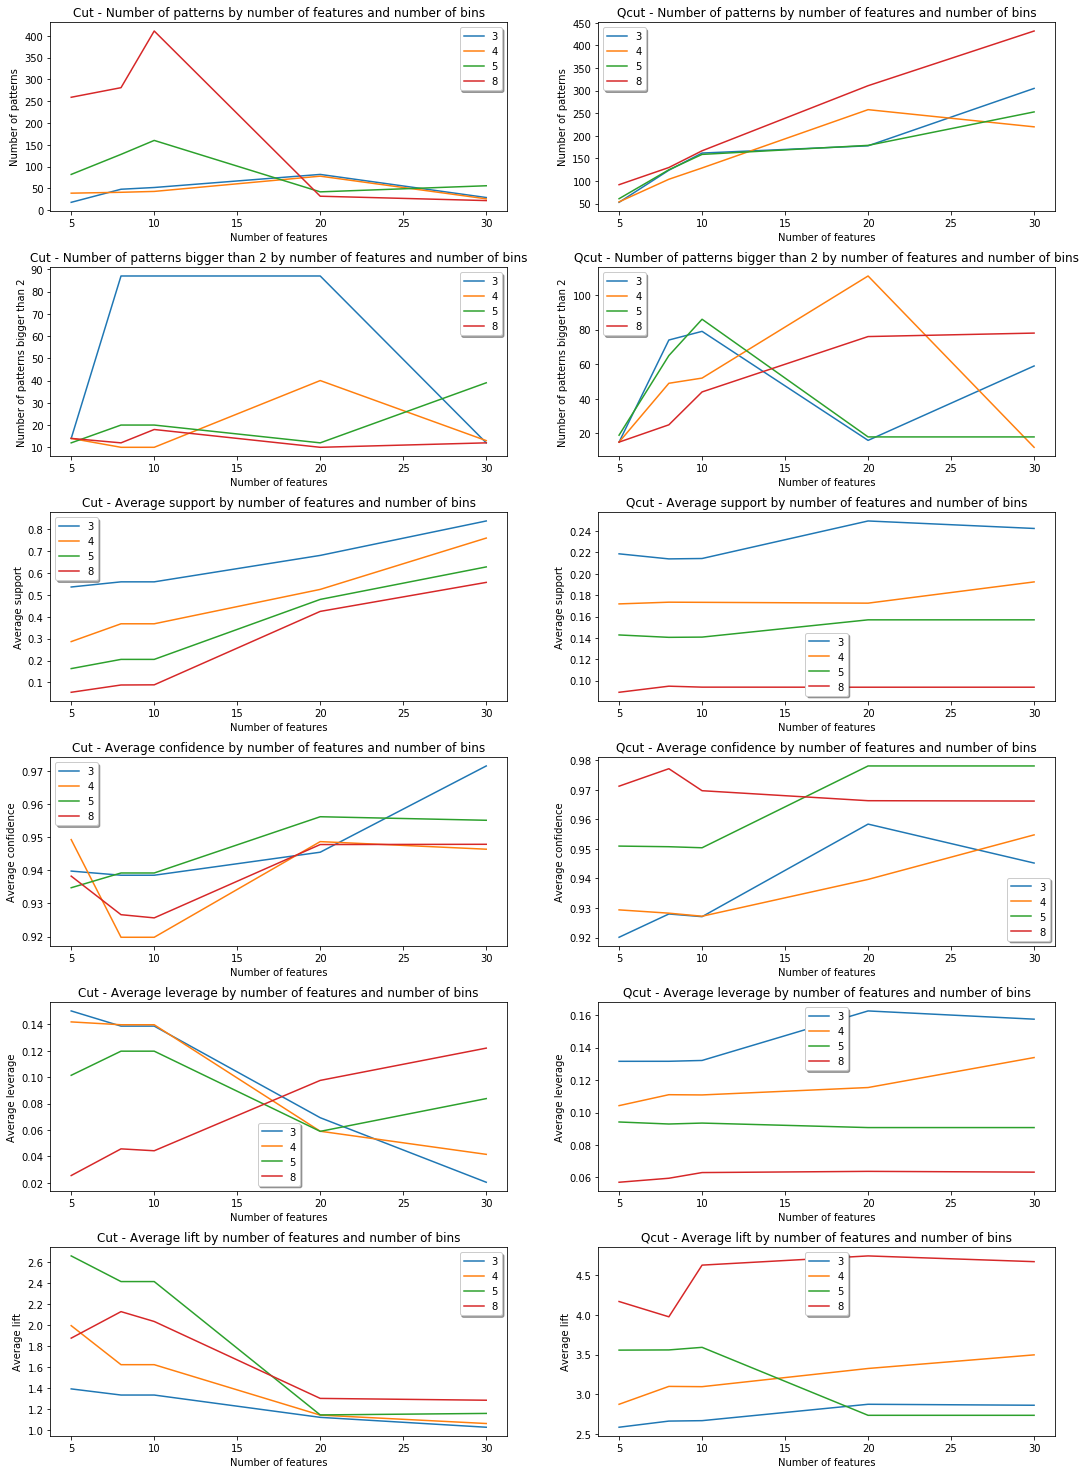

In [4]:
data_9['gender'] = data_9['gender'].round()
num_features = [5, 8, 10, 20, 30]
num_bins = [3, 4, 5, 8]
metrics = ["Number of patterns", "Number of patterns bigger than 2", "Average support", "Average confidence", "Average leverage", "Average lift"]

results_cut, results_qcut = analyzes.pattern_mining_analyzes(data_9, df_target, num_features, num_bins, metrics)

Considering first lift and leverage:
- **Lift**: the ratio of the observed joint probability of X and Y to the expected joint probability if they were statistically independent - $lift(X\Rightarrow Y)= \frac {P(X \cap Y)}{P(X)*P(Y)}$
    - Equal to 1 means that they are independent
    - Greater than 1 means that they are positively correlated
    - Lower than 1 means that they are negatively correlated
- **Leverage**: measures the difference between the observed and expected joint probability of XY assuming that X and Y are independent - $leverage(X\Rightarrow Y) = P(XY) - P(X) - P(Y)$
    - Equal to 0 means that they are independent
    - Greater than 0 means that they are positively correlated
    - Lower than 0 means that they are negatively correlated

Higher averages occur on the qcut, probably because of the influence of outliers that can cause most of values to remain in the same bin on the cut approuch. At the same time, since the most similar values are together, it's "easier" to find relations/rules, and it's indicate by the average support in both cases.

To understand better the rules, we are going to fix the number of features in 10 (to have a reasonable number of features) and the number of bins in 4 and, later, use 8.

## Fixing one value to evaluate the rules

Here, it's going to be done for fixed parameters step by step (first with 4 bins, then with 8)

In [5]:
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X_9, y_9)

print('Shape before feature selection:', X_9.shape)
print('Shape after feature selection:', X_new.shape)

X_new

Shape before feature selection: (376, 350)
Shape after feature selection: (376, 10)


array([[0.69939031, 0.29335769, 0.36829191, ..., 0.3449435 , 0.26159742,
        0.34512721],
       [0.70387003, 0.1356912 , 0.25061078, ..., 0.43332698, 0.3703697 ,
        0.56096346],
       [0.33127886, 0.18803313, 0.2683551 , ..., 0.09554348, 0.69689129,
        0.71519216],
       ...,
       [0.75998743, 0.2337674 , 0.24555083, ..., 0.48092847, 0.45551334,
        0.62350203],
       [0.3105217 , 0.35779378, 0.33035315, ..., 0.33088337, 0.8072876 ,
        0.73873264],
       [0.55351314, 0.0927367 , 0.16032023, ..., 0.22123252, 0.50641209,
        0.46210096]])

In [6]:
cols = selector.get_support(indices=True)

selected_df = data_9.iloc[:, cols].join(df_target)
selected_df.head()

,mean_MFCC_2nd_coef,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,tqwt_entropy_shannon_dec_17,tqwt_entropy_log_dec_12,class
id,,,,,,,,,,,
0,0.699390,0.293358,0.368292,0.111645,0.529850,0.290614,0.210843,0.344943,0.261597,0.345127,1.0
1,0.703870,0.135691,0.250611,0.260413,0.139885,0.296079,0.248315,0.433327,0.370370,0.560963,1.0
2,0.331279,0.188033,0.268355,0.178849,0.195241,0.200090,0.072574,0.095543,0.696891,0.715192,1.0
3,0.434929,0.398089,0.210125,0.444707,0.331524,0.242596,0.143550,0.394110,0.752682,0.713601,1.0
4,0.750377,0.191724,0.265333,0.243838,0.319699,0.386515,0.278107,0.360543,0.109458,0.415387,1.0


## Discretize according to the size of the bins

In [7]:
newdf = selected_df.copy()
for col in newdf:
    if col not in ['class']: 
        newdf[col] = pd.cut(newdf[col],4,labels=['0','1','2','3'])
newdf.head(5)

,mean_MFCC_2nd_coef,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,tqwt_entropy_shannon_dec_17,tqwt_entropy_log_dec_12,class
id,,,,,,,,,,,
0,2,1,1,0,2,1,0,1,1,1,1.0
1,2,0,1,1,0,1,0,1,1,2,1.0
2,1,0,1,0,0,0,0,0,2,2,1.0
3,1,1,0,1,1,0,0,1,3,2,1.0
4,3,0,1,0,1,1,1,1,0,1,1.0


## Discretize according to the number of the elements per bins (similar to quartiles)

In [8]:
newdf_2 = selected_df.copy()
for col in newdf_2:
    if col not in ['class']: 
        newdf_2[col] = pd.qcut(newdf_2[col],4,labels=['0','1','2','3'])
newdf_2.head(5)

,mean_MFCC_2nd_coef,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,tqwt_entropy_shannon_dec_17,tqwt_entropy_log_dec_12,class
id,,,,,,,,,,,
0,3,2,3,0,3,2,1,2,0,0,1.0
1,3,1,1,2,0,2,2,3,1,1,1.0
2,1,1,2,1,1,0,0,0,2,2,1.0
3,1,3,1,3,2,1,0,2,2,2,1.0
4,3,1,2,1,2,2,2,2,0,0,1.0


## Dummify attributes

In [9]:
dummylist = []
for att in newdf:
    if att in ['class']: newdf[att] = newdf[att].astype('category')
    dummylist.append(pd.get_dummies(newdf[[att]]))
dummified_df = pd.concat(dummylist, axis=1)
dummified_df.head(5)

,mean_MFCC_2nd_coef_0,mean_MFCC_2nd_coef_1,mean_MFCC_2nd_coef_2,mean_MFCC_2nd_coef_3,std_6th_delta_0,std_6th_delta_1,std_6th_delta_2,std_6th_delta_3,std_7th_delta_0,std_7th_delta_1,...,tqwt_entropy_shannon_dec_17_0,tqwt_entropy_shannon_dec_17_1,tqwt_entropy_shannon_dec_17_2,tqwt_entropy_shannon_dec_17_3,tqwt_entropy_log_dec_12_0,tqwt_entropy_log_dec_12_1,tqwt_entropy_log_dec_12_2,tqwt_entropy_log_dec_12_3,class_0.0,class_1.0
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
1,0,0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
2,0,1,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1
4,0,0,0,1,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,1


In [10]:
dummylist = []
for att in newdf_2:
    if att in ['class']: newdf_2[att] = newdf_2[att].astype('category')
    dummylist.append(pd.get_dummies(newdf_2[[att]]))
dummified_df_2 = pd.concat(dummylist, axis=1)
dummified_df_2.head(5)

,mean_MFCC_2nd_coef_0,mean_MFCC_2nd_coef_1,mean_MFCC_2nd_coef_2,mean_MFCC_2nd_coef_3,std_6th_delta_0,std_6th_delta_1,std_6th_delta_2,std_6th_delta_3,std_7th_delta_0,std_7th_delta_1,...,tqwt_entropy_shannon_dec_17_0,tqwt_entropy_shannon_dec_17_1,tqwt_entropy_shannon_dec_17_2,tqwt_entropy_shannon_dec_17_3,tqwt_entropy_log_dec_12_0,tqwt_entropy_log_dec_12_1,tqwt_entropy_log_dec_12_2,tqwt_entropy_log_dec_12_3,class_0.0,class_1.0
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,0,0,0,1,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
2,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
3,0,1,0,0,0,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,1
4,0,0,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1


In [11]:
analyzes.apriori_rules(dummified_df)[1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
3,"(std_7th_delta_0, std_8th_delta_0)",(std_6th_delta_0),0.396277,0.614362,0.361702,0.912752,1.485691,0.118245,4.420008,2
4,"(std_9th_delta_0, std_7th_delta_0)",(std_6th_delta_0),0.372340,0.614362,0.351064,0.942857,1.534694,0.122312,6.748670,2
5,"(std_7th_delta_0, std_11th_delta_0)",(std_6th_delta_0),0.396277,0.614362,0.364362,0.919463,1.496615,0.120905,4.788342,2
6,"(std_9th_delta_0, std_8th_delta_0)",(std_6th_delta_0),0.396277,0.614362,0.367021,0.926174,1.507539,0.123564,5.223646,2
7,"(std_6th_delta_0, std_8th_delta_0)",(std_11th_delta_0),0.430851,0.550532,0.393617,0.913580,1.659450,0.156420,5.200988,2
8,"(std_9th_delta_0, std_11th_delta_0)",(std_6th_delta_0),0.409574,0.614362,0.372340,0.909091,1.479732,0.120714,4.242021,2
9,"(std_7th_delta_0, std_11th_delta_0)",(std_8th_delta_0),0.396277,0.492021,0.361702,0.912752,1.855106,0.166726,5.822218,2
10,"(std_7th_delta_0, std_8th_delta_0)",(std_11th_delta_0),0.396277,0.550532,0.361702,0.912752,1.657945,0.143539,5.151596,2
11,"(std_9th_delta_0, std_11th_delta_0)",(std_8th_delta_0),0.409574,0.492021,0.372340,0.909091,1.847666,0.170821,5.587766,2
12,"(std_9th_delta_0, std_8th_delta_0)",(std_11th_delta_0),0.396277,0.550532,0.372340,0.939597,1.706708,0.154178,7.441194,2


When divided by equal sized bins, the rules created associate only the values from the first bin of the features related to std delta.

In [12]:
analyzes.apriori_rules(dummified_df_2)[1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
2,"(std_6th_delta_3, std_7th_delta_3)",(std_8th_delta_3),0.194149,0.250000,0.180851,0.931507,3.726027,0.132314,10.950000,2
3,"(std_6th_delta_3, std_8th_delta_3)",(std_7th_delta_3),0.194149,0.250000,0.180851,0.931507,3.726027,0.132314,10.950000,2
4,"(std_7th_delta_3, std_8th_delta_3)",(std_6th_delta_3),0.194149,0.250000,0.180851,0.931507,3.726027,0.132314,10.950000,2
5,"(std_6th_delta_3, std_9th_delta_3)",(std_7th_delta_3),0.178191,0.250000,0.167553,0.940299,3.761194,0.123005,12.562500,2
6,"(std_9th_delta_3, std_7th_delta_3)",(std_6th_delta_3),0.186170,0.250000,0.167553,0.900000,3.600000,0.121011,7.500000,2
7,"(std_6th_delta_3, std_7th_delta_3)",(std_10th_delta_3),0.194149,0.250000,0.175532,0.904110,3.616438,0.126995,7.821429,2
8,"(std_6th_delta_3, std_10th_delta_3)",(std_7th_delta_3),0.188830,0.250000,0.175532,0.929577,3.718310,0.128324,10.650000,2
9,"(std_7th_delta_3, std_10th_delta_3)",(std_6th_delta_3),0.191489,0.250000,0.175532,0.916667,3.666667,0.127660,9.000000,2
10,"(std_6th_delta_3, std_7th_delta_3)",(class_1.0),0.194149,0.500000,0.180851,0.931507,1.863014,0.083777,7.300000,2
11,"(std_10th_delta_3, std_8th_delta_3)",(std_6th_delta_3),0.183511,0.250000,0.167553,0.913043,3.652174,0.121676,8.625000,2


When divided in quartiles, most of the rules created associate the values from the last quartile of the features related to std delta. But it's interesting to note that some of the rules have the class_1.0, so it can be useful to detect the target class.

## With more bins

In [13]:
newdf = selected_df.copy()
for col in newdf:
    if col not in ['class','a01','a02']: 
        newdf[col] = pd.qcut(newdf[col],8,labels=range(8))

dummylist = []
for att in newdf:
    if att in ['class']: newdf[att] = newdf[att].astype('category')
    dummylist.append(pd.get_dummies(newdf[[att]]))
dummified_df_3 = pd.concat(dummylist, axis=1)

analyzes.apriori_rules(dummified_df_3)[1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
8,"(std_7th_delta_7, std_6th_delta_7)",(class_1.0),0.093085,0.50000,0.093085,1.000000,2.000000,0.046543,inf,2
9,"(std_6th_delta_7, std_8th_delta_7)",(std_9th_delta_7),0.095745,0.12500,0.090426,0.944444,7.555556,0.078457,15.750000,2
10,"(std_6th_delta_7, std_8th_delta_7)",(class_1.0),0.095745,0.50000,0.095745,1.000000,2.000000,0.047872,inf,2
11,"(std_6th_delta_7, std_9th_delta_7)",(class_1.0),0.103723,0.50000,0.103723,1.000000,2.000000,0.051862,inf,2
12,"(std_6th_delta_7, std_10th_delta_7)",(class_1.0),0.098404,0.50000,0.098404,1.000000,2.000000,0.049202,inf,2
13,"(std_11th_delta_7, std_6th_delta_7)",(class_1.0),0.095745,0.50000,0.095745,1.000000,2.000000,0.047872,inf,2
14,"(std_6th_delta_7, std_12th_delta_7)",(class_1.0),0.093085,0.50000,0.093085,1.000000,2.000000,0.046543,inf,2
15,"(std_7th_delta_7, std_8th_delta_7)",(class_1.0),0.095745,0.50000,0.095745,1.000000,2.000000,0.047872,inf,2
16,"(std_7th_delta_7, std_10th_delta_7)",(class_1.0),0.090426,0.50000,0.090426,1.000000,2.000000,0.045213,inf,2
17,"(std_11th_delta_7, std_8th_delta_7)",(std_9th_delta_7),0.098404,0.12500,0.093085,0.945946,7.567568,0.080785,16.187500,2


Once again, the last bin indicate rules associated to the class = 1, which indicate that a high value for these features may be a warning for the Parkinson. This makes sense, because these attributes are the standard deviations of the coefficients of the Discrete Wavelet Transform, and a higher value may indicate more noise / tremor in the voice, which is a Parkinson's symptom.

We will verify it plotting some graphs below.

Besides that, we can see that a greater number of bins result in a lower minimum support, because of the higher number of possibilities for each feature, making each value less frequent.

<Figure size 432x288 with 0 Axes>

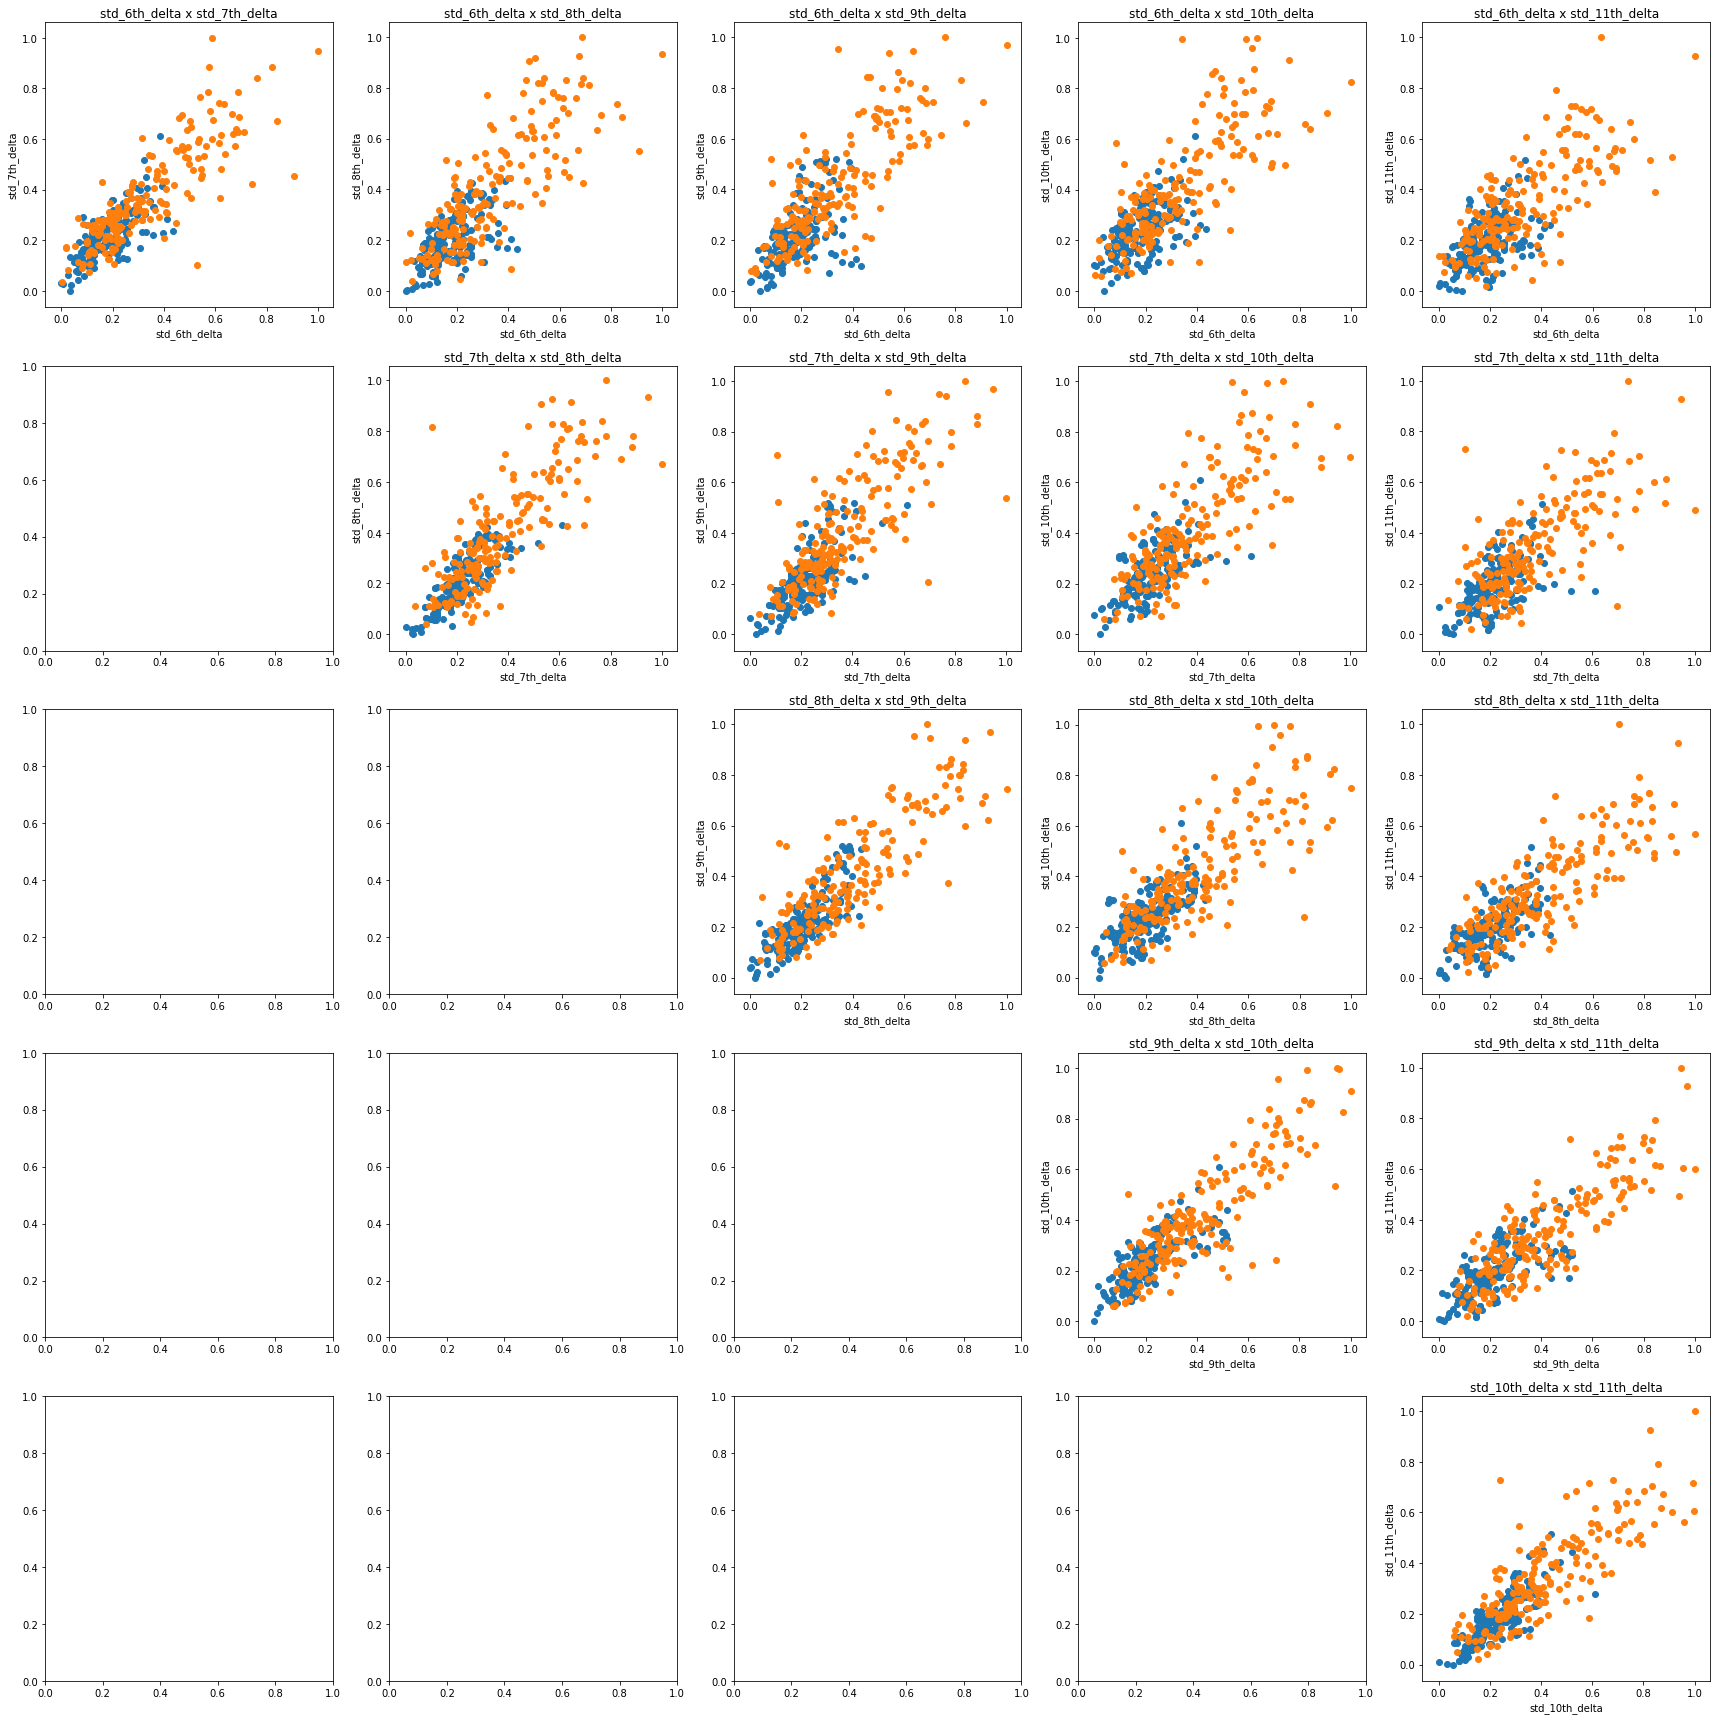

In [14]:
sparsity = selected_df[['std_6th_delta', 'std_7th_delta', 'std_8th_delta', 'std_9th_delta', 'std_10th_delta', 'std_11th_delta', 'class']].columns
plt.figure()
rows, cols = len(sparsity)-1, len(sparsity)-1
fig, axs = plt.subplots(rows-1, cols-1, figsize=(cols*4, rows*4), squeeze=False)
for i in range(len(sparsity)-1):
    var1 = sparsity[i]
    for j in range(i+1, len(sparsity)-1):
        var2 = sparsity[j]
        graph.scatter_with_two_classes(axs[i, j-1], selected_df[selected_df['class']==0], selected_df[selected_df['class']==1], var1, var2)
fig.tight_layout()
plt.show()

As we mencioned, a high value of these variables looks to be a good indicator for the Parkinson disease, but a low one doesn't help as much.